# World Bank Group Finances

### [About World Bank Group Fiances](https://financesapp.worldbank.org/en/about/)

> WBG Finances is a World Bank Group digital platform that provides our clients and partners access to public financial data and portfolio information from across all Group entities in one place.

> WBG Finances ***simplifies*** the presentation of financial information in an _'easy to consume'_ and in the context of Country and Portfolio across WBG.

> All the data presented is available to everybody to analyze, visualize, and share with others. We invite you to explore the numerous tools, build your own visualizations or download the data in multiple forms. If you are a developer, connect to it through the APIs associated with all the datasets.

> So get started and:
>1. Explore the [Financial Summaries](https://financesapp.worldbank.org/en/summaries/ibrd-ida/) or [Country Summaries](https://financesapp.worldbank.org/en/countries/) for your country
>2. Download our [iPhone/iPad](https://itunes.apple.com/app/world-bank-finances/id465555488?mt=8) app or [Android](https://play.google.com/store/apps/details?id=com.worldbank.finances) app
>3. [Read the Terms of Use](https://financesapp.worldbank.org/en/terms/) associated with the use of data

> Please note that the datasets are raw and may not have been audited yet.

> For official data on the World Bank Group's finances please refer to:
>- [World Bank's Annual Report](http://www.worldbank.org/en/about/annual-report)
>- [IFC Annual Report](http://www.ifc.org/wps/wcm/connect/CORP_EXT_Content/IFC_External_Corporate_Site/Annual+Report/)
>- [MIGA's Annual Report](https://www.miga.org/Pages/Resources/Reports.aspx)

> Please also visit other data on the [World Bank open data website](http://data.worldbank.org/).

> The World Bank Group recognizes that transparency and accountability are essential to the develoment process and central to achieving the World Bank Group's mission to alleviate poverty. The World Bank Group's commitment to openness is also driven by a desire to foster public ownership, partnership and participation in development from a wide range of stakeholders. As a knowledge institution, the World Bank Group's first step is to share its knowledge freely and openly.

> In fulfilling its responsibilities, the World Bank Group complies with all sanctions applicable to World Bank Group transactions.

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

# The usual suspects ...
import pandas as pd
import numpy as np
import missingno as msn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

# And their accomplices
from sodapy import Socrata
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

# Plotting settings
sns.set(context='notebook', style='whitegrid', palette='deep', rc=None)

In [2]:
# Getting the data
# 1. Authentication
client = Socrata(domain='finances.worldbank.org', 
                 app_token='myapptoken', 
                 username='myname@whatever.com',
                 password='myfakepassword')

# 2. Conneting and extracting top 5000 results
results = client.get('8iaw-pcc6', limit=50000)

# 3. Convert to pandas dataframe
df = pd.DataFrame.from_records(results)

# Top 5 rows
df.shape

(8644, 32)

In [3]:
# Data types
df.dtypes

agreement_signing_date         object
board_approval_date            object
borrower                       object
borrower_s_obligation          object
cancelled_amount               object
closed_date_most_recent_       object
country                        object
country_code                   object
disbursed_amount               object
due_3rd_party                  object
due_to_ibrd                    object
effective_date_most_recent_    object
end_of_period                  object
exchange_adjustment            object
first_repayment_date           object
guarantor                      object
guarantor_country_code         object
interest_rate                  object
last_disbursement_date         object
last_repayment_date            object
loan_number                    object
loan_status                    object
loan_type                      object
loans_held                     object
original_principal_amount      object
project_id                     object
project_name

All the data is of the same type, that is, an `object`. We have to change this to the appropriate data type.

In [4]:
# Value converter
def value_converter(data, string, value_type):
    try:
        for i in zip(data.columns.str.contains(string), data.columns):
            if (i[0] == True and value_type == 'time'):
                data[i[1]] = pd.to_datetime(df[i[1]], format='%Y-%m-%d')
            if (i[0] == True and value_type == 'floating'):
                data[i[1]] = data[i[1]].astype(np.float)
            if (i[0] == True and value_type == 'integer'):
                data[i[1]] = data[i[1]].astype(np.int)
    except ValueError as a:
        print(a)

# Changing to datetime format
value_converter(data=df, string='date', value_type='time')
value_converter(data=df, string='period', value_type='time')

# Changing to floating point values
value_converter(data=df, string='amount', value_type='floating')
value_converter(data=df, string='due', value_type='floating')
value_converter(data=df, string='rate', value_type='floating')
value_converter(data=df, string='repaid', value_type='floating')
value_converter(data=df, string='sold', value_type='floating')
value_converter(data=df, string='loans_held', value_type='floating')
value_converter(data=df, string='exchange_adjustment', value_type='floating')
value_converter(data=df, string='borrower_s_obligation', value_type='floating')

# Checking the data types after convertion
df.dtypes

agreement_signing_date         datetime64[ns]
board_approval_date            datetime64[ns]
borrower                               object
borrower_s_obligation                 float64
cancelled_amount                      float64
closed_date_most_recent_       datetime64[ns]
country                                object
country_code                           object
disbursed_amount                      float64
due_3rd_party                         float64
due_to_ibrd                           float64
effective_date_most_recent_    datetime64[ns]
end_of_period                  datetime64[ns]
exchange_adjustment                   float64
first_repayment_date           datetime64[ns]
guarantor                              object
guarantor_country_code                 object
interest_rate                         float64
last_disbursement_date         datetime64[ns]
last_repayment_date            datetime64[ns]
loan_number                            object
loan_status                       

In [5]:
# Top 3 rows, transposed
df.head(3).T

,0,1,2
agreement_signing_date,1947-05-09 00:00:00,1947-08-07 00:00:00,1948-05-25 00:00:00
board_approval_date,1947-05-09 00:00:00,1947-08-07 00:00:00,1947-08-07 00:00:00
borrower,CREDIT NATIONAL,NaN,NaN
borrower_s_obligation,0,0.01,0
cancelled_amount,0,0,0
closed_date_most_recent_,1947-12-31 00:00:00,1948-03-31 00:00:00,1948-06-30 00:00:00
country,France,Netherlands,Netherlands
country_code,FR,NL,NL
disbursed_amount,2.5e+08,1.91044e+08,3.95579e+06
due_3rd_party,0,0,0


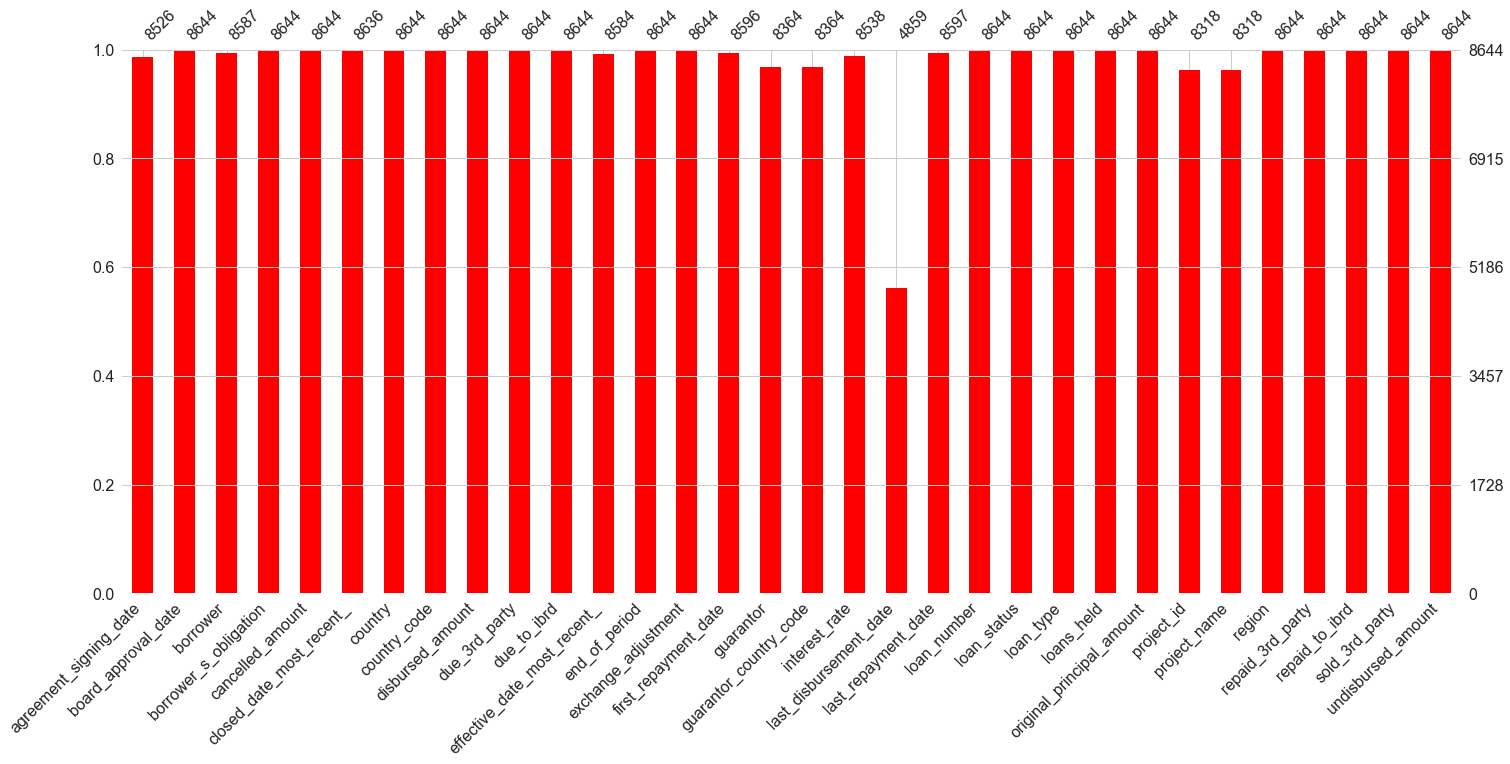

In [6]:
# Missing values
msn.bar(df, color='red')

`last_disbursement_date` has over 50% of its data missing. We will drop this column, then fill in the missing values in `project name`, `project id`, `guarantor` and `guarantor_country_code`.

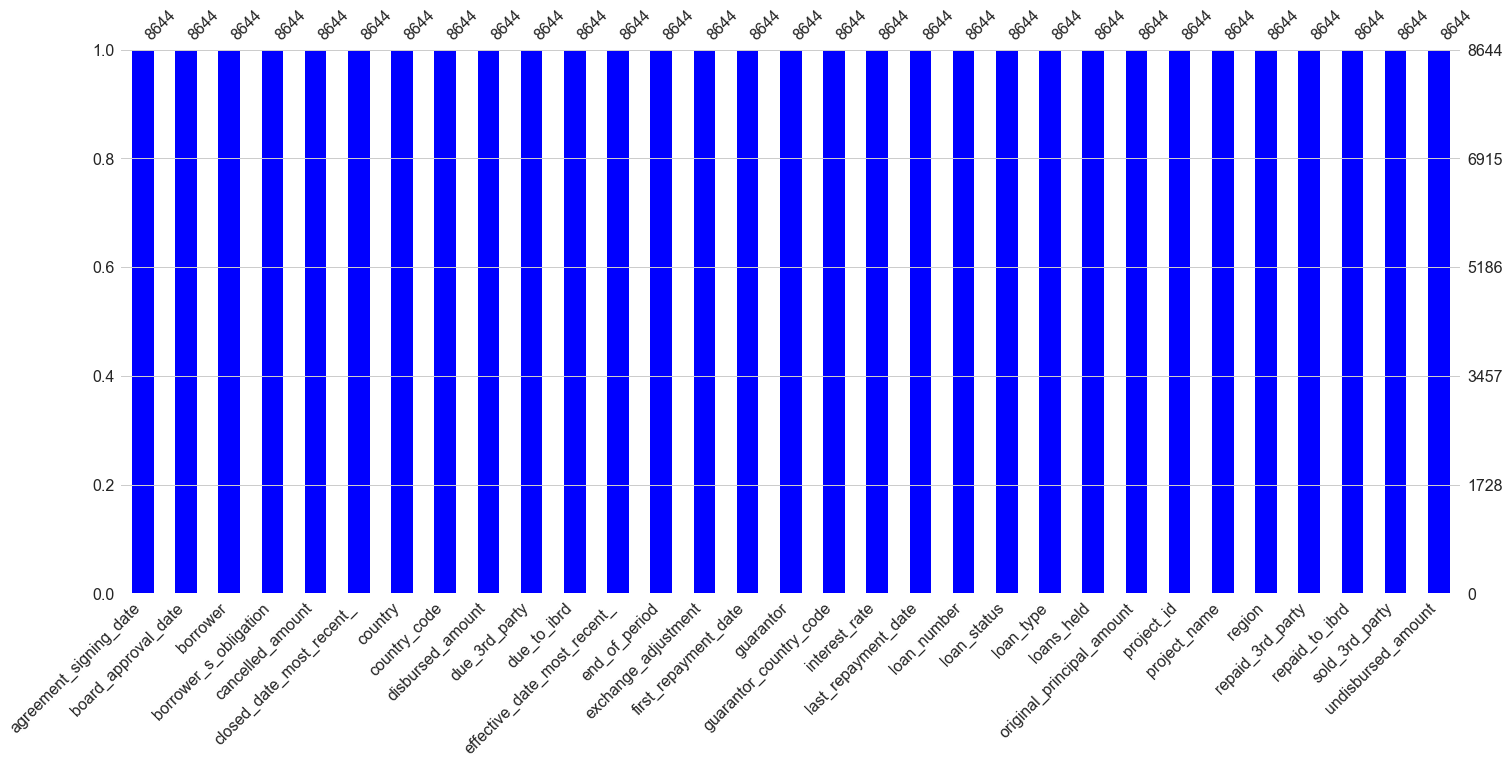

In [7]:
# Reshaping the dataframe
df = df.drop('last_disbursement_date', axis=1)

# Filling in missing values
df = df.fillna(method='backfill')

# Checking for missing values
msn.bar(df, color='blue')

### Time Series Analysis

In [8]:
# Plotting function
def plot_series(series, 
                title=None, xlabel=None, ylabel=None, 
                marker_style='blue'):
    # Plotting the time series
    plt.figure(figsize=(22, 10))
    plt.plot(series, marker_style )
    plt.title(title, fontsize=24)
    plt.xlabel(xlabel, fontsize=16)
    plt.xticks(fontsize=12)
    plt.ylabel(ylabel, fontsize=16)
    plt.yticks(fontsize=12)

In [9]:
# Testing for stationarity
def test_stationarity(data):
    
    #Determing rolling statistics
    rolmean = data.rolling(window=12, center=False).mean().dropna()
    rolstd = data.rolling(window=12, center=False).std().dropna()

    #Plot rolling statistics:
    plt.figure(figsize=(22, 10))
    orig = plt.plot(data, 'ro',label='Original')
    mean = plt.plot(rolmean, 'bo', label='Rolling Mean')
    std = plt.plot(rolstd, 'go', label = 'Rolling Standard Deviation')
    plt.legend(loc='best', fontsize='x-large')
    plt.title('Rolling Mean & Standard Deviation', fontsize=24)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    try:
        dftest = adfuller(data, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                                 'p-value',
                                                 '#Lags Used',
                                                 'Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value ({})'.format(key)] = value
        print(dfoutput)
    except ValueError as a:
        print(a)
    except NameError as c:
        print(c)

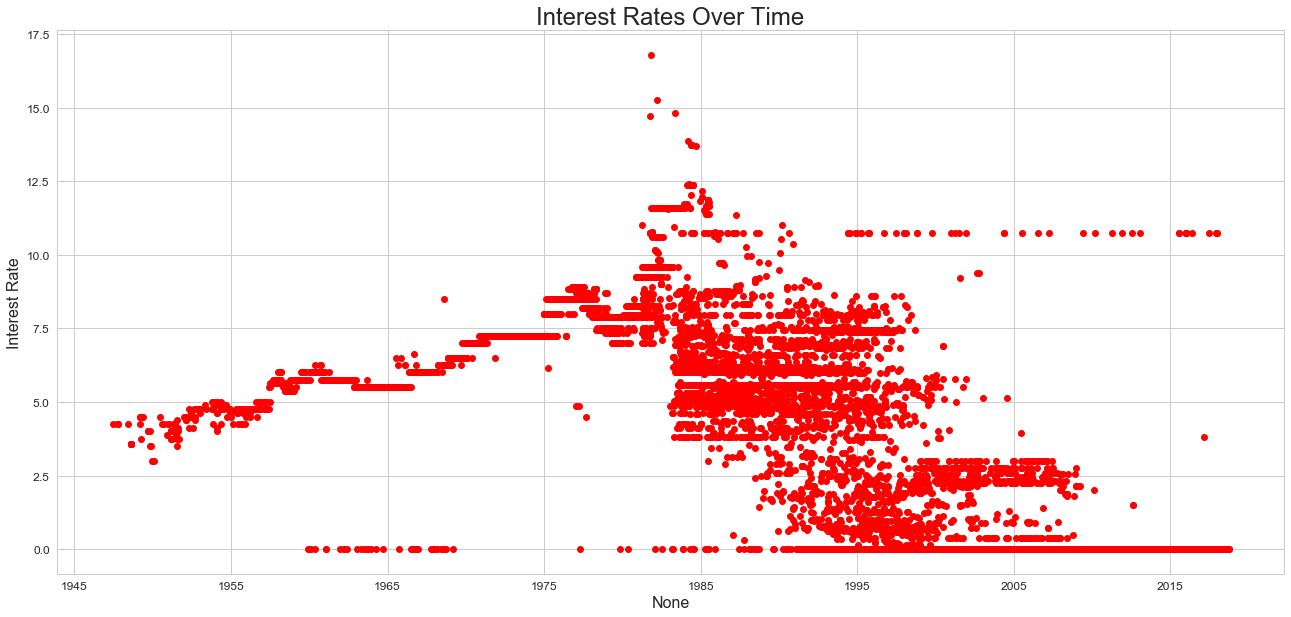

In [10]:
# Interest rates
d = df[['interest_rate', 'effective_date_most_recent_']]
interest_rates = d.set_index('effective_date_most_recent_')['interest_rate']

# Plot series
plot_series(interest_rates, title='Interest Rates Over Time', ylabel='Interest Rate', marker_style='ro')

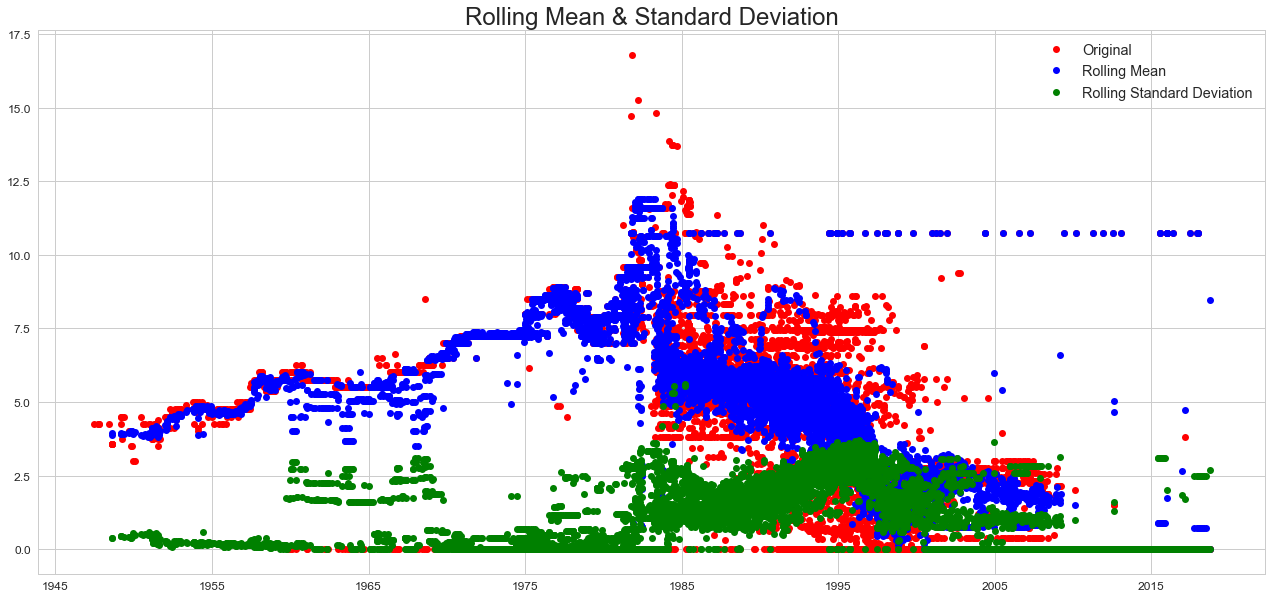

Results of Dickey-Fuller Test:
Test Statistic                   -2.221330
p-value                           0.198595
#Lags Used                       34.000000
Number of Observations Used    8609.000000
Critical Value (1%)              -3.431110
Critical Value (5%)              -2.861876
Critical Value (10%)             -2.566949
dtype: float64


In [11]:
# Testing for stationarity
test_stationarity(interest_rates)

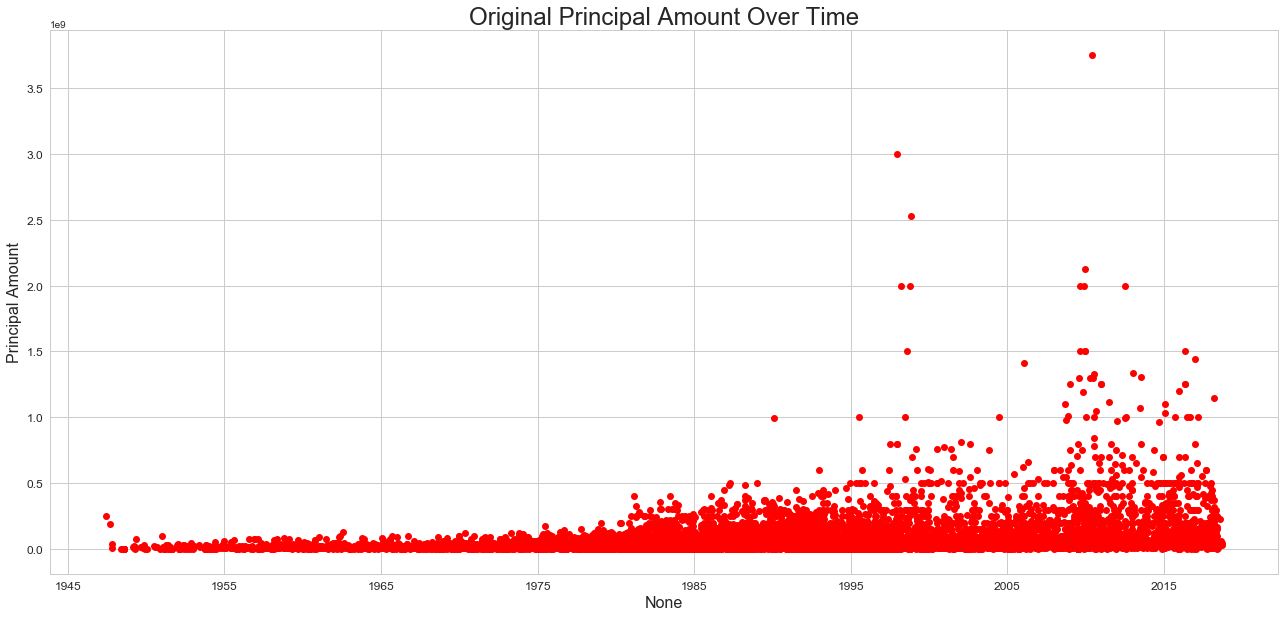

In [12]:
# Original principal amount
d = df[['original_principal_amount', 'effective_date_most_recent_']]
original_principal_amount = d.set_index('effective_date_most_recent_')['original_principal_amount']

# Plotting
plot_series(original_principal_amount, title='Original Principal Amount Over Time', ylabel='Principal Amount', marker_style='ro')

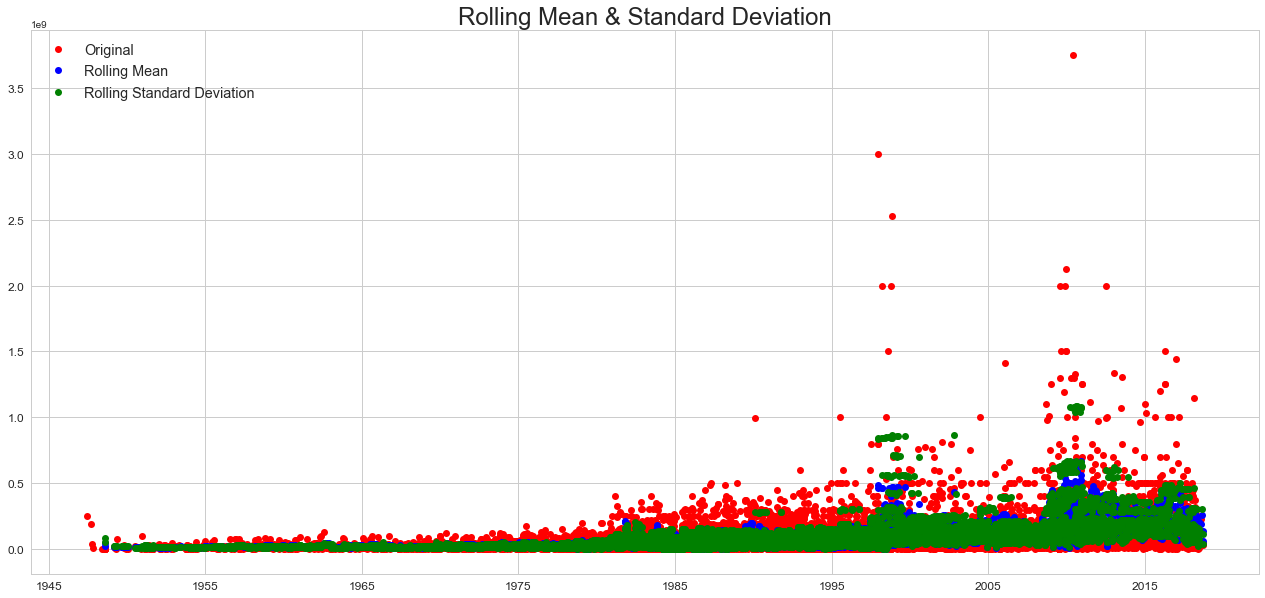

Results of Dickey-Fuller Test:
Test Statistic                -6.814155e+00
p-value                        2.079696e-09
#Lags Used                     3.700000e+01
Number of Observations Used    8.606000e+03
Critical Value (1%)           -3.431110e+00
Critical Value (5%)           -2.861876e+00
Critical Value (10%)          -2.566949e+00
dtype: float64


In [13]:
test_stationarity(original_principal_amount)